### This notebook solves the 1D Poisson's equation using both DeepRitz and PINN
$$-u''(x) = f(x)$$
with Dirichlet boundary condition $u(x=0) = u(x=1) = 0$.

Some codes below were adapted from https://github.com/JiantingFeng/Deep-Ritz-PDE-Solver

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import optim, autograd
from tqdm import tqdm
from chp08_nn import *
import copy

In [2]:
k = 2
f = lambda x : torch.sin(torch.pi*k*x)
exact_u = lambda x : np.sin(np.pi*k*x)/(k**2*np.pi**2)
torch.manual_seed(1);

In [3]:
def Poisson_solver(model_init, method_name='Ritz', eps=0.005, \
                   EPOCH=10000, lr=1.0e-3, num_samples=100, λ=500):

    # initialize the model
    model = copy.deepcopy(model_init)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_vec = np.zeros(EPOCH)
    bar = tqdm(range(EPOCH))

    model.train()
    for j in bar:
        bar.set_description("Training Epoch for " + method_name + " "+ str(j))

        optimizer.zero_grad()

        xb = torch.tensor([[0.0], [1.0]], requires_grad=True)
        output_b = model(xb)
        
        if method_name == "Ritz":
            xr = torch.rand(num_samples,requires_grad=True).view((num_samples,1))
            output_r = model(xr)
            grads = autograd.grad(
                outputs=output_r,
                inputs=xr,
                grad_outputs=torch.ones_like(output_r),
                create_graph=True,
                retain_graph=True,
                only_inputs=True,
            )[0]
            loss_r = 0.5 * torch.sum(torch.pow(grads, 2), dim=1)
            loss_r = torch.mean(loss_r) - torch.mean(f(xr)*output_r)

        elif method_name == "PINN-1":
            xr = torch.rand(num_samples,requires_grad=True).view((num_samples,1))
            output_r = model(xr)
            grads = autograd.grad(
                outputs=output_r,
                inputs=xr,
                grad_outputs=torch.ones_like(output_r),
                create_graph=True,
                retain_graph=True,
                only_inputs=True,
            )[0]

            hess = autograd.grad(
                outputs=grads,
                inputs=xr,
                grad_outputs=torch.ones_like(grads),
                create_graph=True,
                retain_graph=True,
                only_inputs=True,
            )[0]
            loss_r = torch.mean(torch.pow(hess + f(xr),2))
            
        elif method_name == "PINN-2":
            xr = eps + (1-2*eps)*torch.rand(num_samples,requires_grad=True).view((num_samples,1))
            output_r = model(xr)
            hess = (model(xr + eps) + model(xr - eps) - 2 * output_r)/eps**2
            loss_r = torch.mean(torch.pow(hess + f(xr),2))

        loss_b = torch.mean(torch.pow(output_b, 2))
        loss = loss_r + λ * loss_b
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_vec[j] = loss.item()
        
    return model, loss_vec

Text(0.5, 1.0, 'Before optimizing')

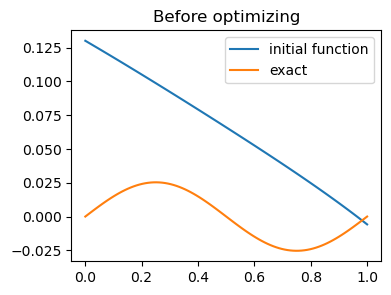

In [4]:
input_size=1
hidden_size=30
output_size=1
torch.manual_seed(1);
model_init = DeepRitz(input_size, hidden_size, output_size)

xmin = 0
xmax = 1
steps = 100
input_tensor = torch.linspace(xmin, xmax,steps=steps,requires_grad=True).view((steps,1))    
x_grid = input_tensor.detach().numpy()

plt.figure(figsize=(4,3))
plt.plot(x_grid, model_init(input_tensor).view(steps).detach().numpy(), \
             label="initial function")
plt.plot(x_grid, exact_u(x_grid), label="exact")
plt.legend()
plt.title('Before optimizing')

Training Epoch for PINN-2 9999: 100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 709.04it/s]


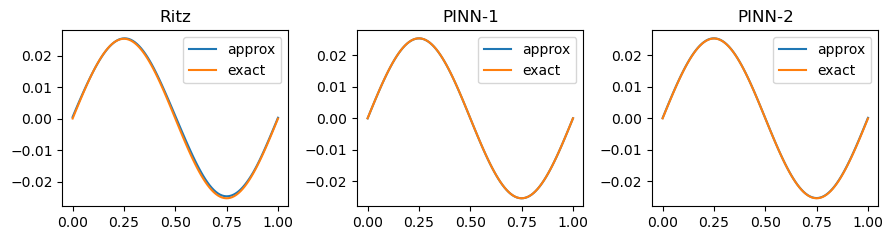

In [5]:
plt.figure(figsize=(9,2.5))

EPOCH = 10**4
name_list = ["Ritz", "PINN-1", "PINN-2"]

for i in range(3):
    
    method_name = name_list[i]
    model, loss_vec = Poisson_solver(model_init, method_name=method_name, EPOCH=EPOCH)

    plt.subplot(1,3,i+1)
    plt.plot(x_grid, model(input_tensor).view(steps).detach().numpy(), label="approx")
    plt.plot(x_grid, exact_u(x_grid), label="exact")
    plt.title(method_name)
    plt.legend()

plt.tight_layout()